In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from transformers import BertTokenizer, TFAutoModel

# Load dataset
dataset = pd.read_csv('/content/TurkishTweets.csv')
dataset = dataset.dropna(subset=['Tweet'])

# Encode labels
label_encoder = LabelEncoder()
dataset['Etiket'] = label_encoder.fit_transform(dataset['Etiket'])
X = dataset['Tweet'].tolist()
y = dataset['Etiket'].values
num_classes = len(label_encoder.classes_)

# Tokenizer & model
model_name = "dbmdz/bert-base-turkish-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = TFAutoModel.from_pretrained(model_name)

# Tokenization
def tokenize(texts, max_len=100):
    return tokenizer(
        texts,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_encodings = tokenize(X_train)
test_encodings = tokenize(X_test)

# Create model (with fine-tuning)
input_ids = tf.keras.Input(shape=(100,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.Input(shape=(100,), dtype=tf.int32, name="attention_mask")

bert_output = bert_model(input_ids, attention_mask=attention_mask)[0]
cls_token = bert_output[:, 0, :]  # [CLS] token
x = tf.keras.layers.Dense(128, activation='relu')(cls_token)
x = tf.keras.layers.Dropout(0.3)(x)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train
history = model.fit(
    x={'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask']},
    y=y_train,
    validation_data=(
        {'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask']},
        y_test
    ),
    epochs=4,
    batch_size=16
)

# Evaluate
y_pred_probs = model.predict({'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask']})
y_pred = np.argmax(y_pred_probs, axis=1)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/251k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/4


200/200 [==============================] - 118s 386ms/step - loss: 0.9844 - accuracy: 0.6036 - val_loss: 0.0612 - val_accuracy: 0.9800
Epoch 2/4
200/200 [==============================] - 74s 367ms/step - loss: 0.0765 - accuracy: 0.9812 - val_loss: 0.0565 - val_accuracy: 0.9837
Epoch 3/4
200/200 [==============================] - 69s 345ms/step - loss: 0.0262 - accuracy: 0.9937 - val_loss: 0.0670 - val_accuracy: 0.9825
Epoch 4/4
25/25 [==============================] - 7s 203ms/step
Accuracy: 0.99125
Classification Report:
              precision    recall  f1-score   support

       korku       1.00      1.00      1.00       164
      kızgın       0.99      0.99      0.99       169
       mutlu       0.98      0.98      0.98       160
     surpriz       1.00      0.99      0.99       156
       üzgün       0.99      0.99      0.99       151

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99    

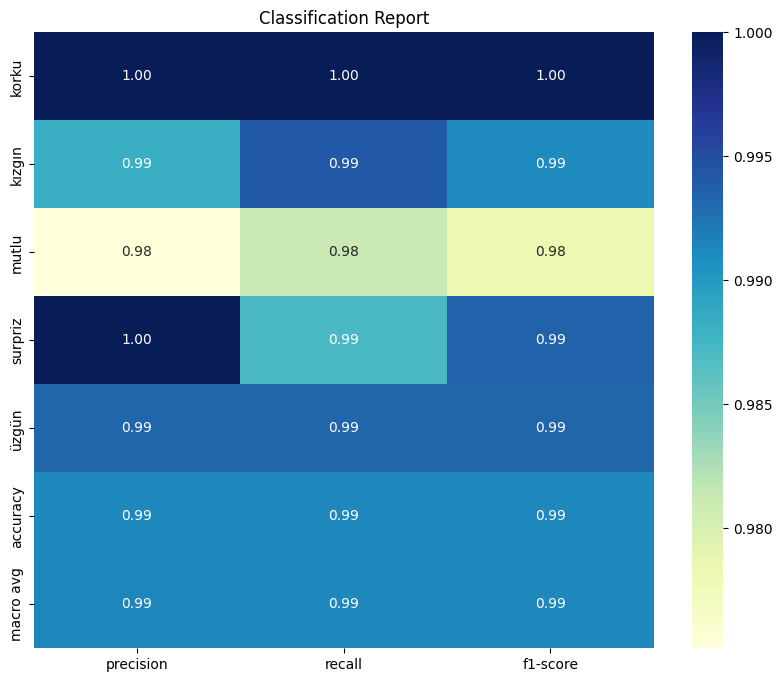

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Eksik tanımlamaları tamamla
labels = sorted(list(set(y_test)))
target_names = label_encoder.inverse_transform(labels).astype(str)

# Classification Report Visualization
from sklearn.metrics import classification_report
classification_report_dict = classification_report(
    y_test, y_pred,
    labels=labels,
    target_names=target_names,
    zero_division=0,
    output_dict=True
)

classification_report_df = pd.DataFrame(classification_report_dict).transpose()

plt.figure(figsize=(10, 8))
sns.heatmap(classification_report_df.iloc[:-1, :-1], annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Classification Report')
plt.show()


SVM Accuracy: 0.9725
SVM Classification Report:
              precision    recall  f1-score   support

       korku       0.99      0.96      0.98       164
      kızgın       0.98      0.98      0.98       169
       mutlu       0.97      0.96      0.97       160
     surpriz       0.96      0.98      0.97       156
       üzgün       0.96      0.98      0.97       151

    accuracy                           0.97       800
   macro avg       0.97      0.97      0.97       800
weighted avg       0.97      0.97      0.97       800

------------------------------------------------------
Random Forest Accuracy: 0.96375
Random Forest Classification Report:
              precision    recall  f1-score   support

       korku       0.98      0.98      0.98       164
      kızgın       0.89      0.98      0.94       169
       mutlu       0.98      0.96      0.97       160
     surpriz       0.99      0.98      0.99       156
       üzgün       0.99      0.92      0.95       151

    accuracy 

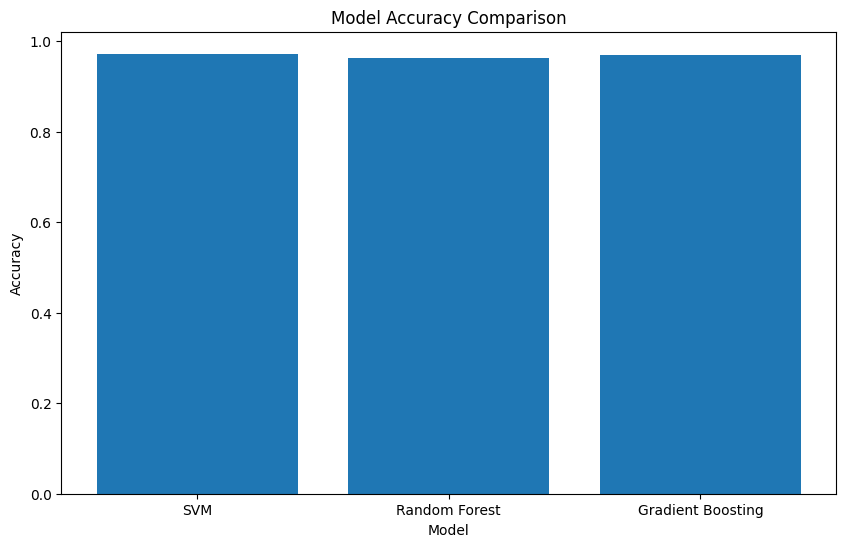

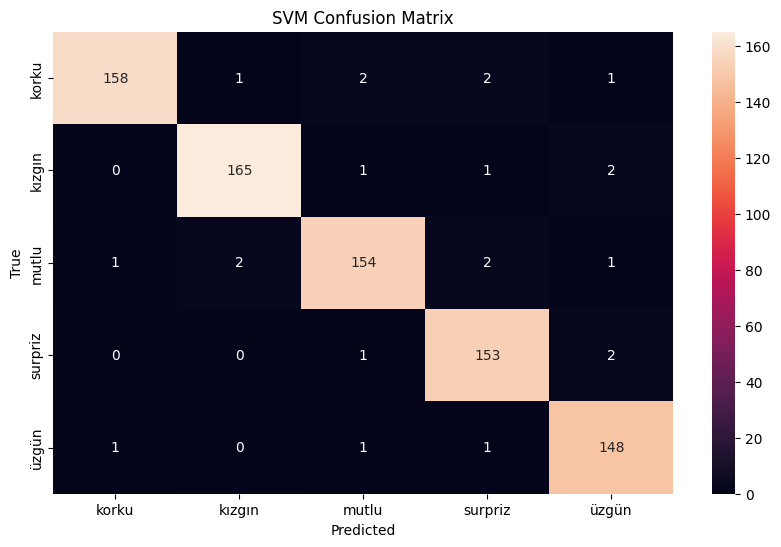

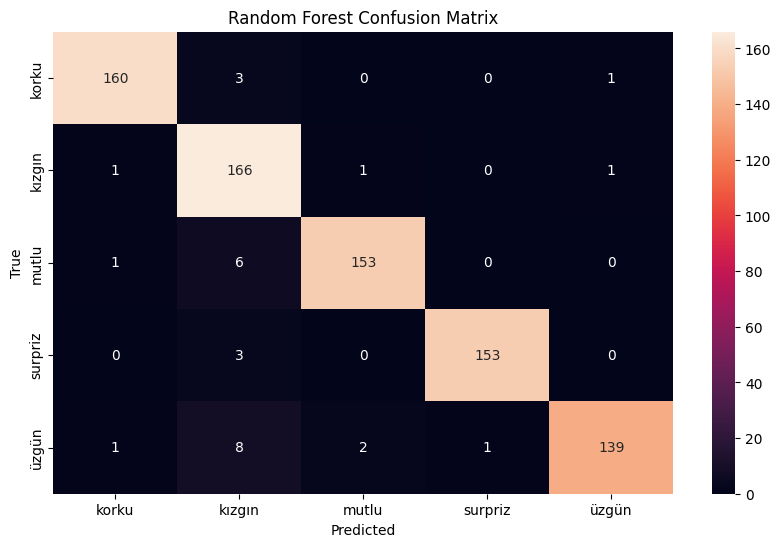

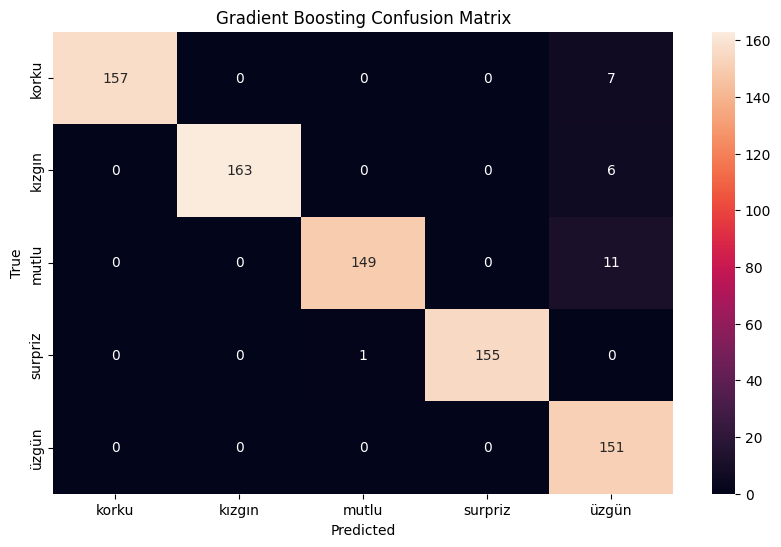

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Load dataset
file_path = '/content/TurkishTweets.csv'
dataset = pd.read_csv(file_path)

# Drop rows with NaN values in 'Tweet' column
dataset = dataset.dropna(subset=['Tweet'])

# Extract features and labels
X = dataset['Tweet']
y = dataset['Etiket']

# Encode sentiment labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess text data using TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Function to train and evaluate a model
def train_evaluate_model(model, model_name):
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    labels = sorted(list(set(y_test)))
    target_names = label_encoder.inverse_transform(labels).astype(str)
    report = classification_report(y_test, y_pred, labels=labels, target_names=target_names, zero_division=0)
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    print(f'{model_name} Accuracy: {accuracy}')
    print(f'{model_name} Classification Report:')
    print(report)
    print('------------------------------------------------------')
    return accuracy, cm, target_names

# Train and evaluate models
models = {
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

accuracies = {}
confusion_matrices = {}
for model_name, model in models.items():
    accuracy, cm, target_names = train_evaluate_model(model, model_name)
    accuracies[model_name] = accuracy
    confusion_matrices[model_name] = (cm, target_names)

# Plot accuracies
plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values())
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.show()

# Plot confusion matrices
for model_name, (cm, target_names) in confusion_matrices.items():
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()


SVM Accuracy: 0.97125
SVM Classification Report:
              precision    recall  f1-score   support

       korku       0.99      0.97      0.98       164
      kızgın       0.98      0.98      0.98       169
       mutlu       0.97      0.95      0.96       160
     surpriz       0.97      0.98      0.98       156
       üzgün       0.95      0.97      0.96       151

    accuracy                           0.97       800
   macro avg       0.97      0.97      0.97       800
weighted avg       0.97      0.97      0.97       800

------------------------------------------------------
Random Forest Accuracy: 0.96625
Random Forest Classification Report:
              precision    recall  f1-score   support

       korku       0.99      0.97      0.98       164
      kızgın       0.91      0.98      0.95       169
       mutlu       0.97      0.94      0.96       160
     surpriz       0.99      0.98      0.99       156
       üzgün       0.97      0.95      0.96       151

    accuracy

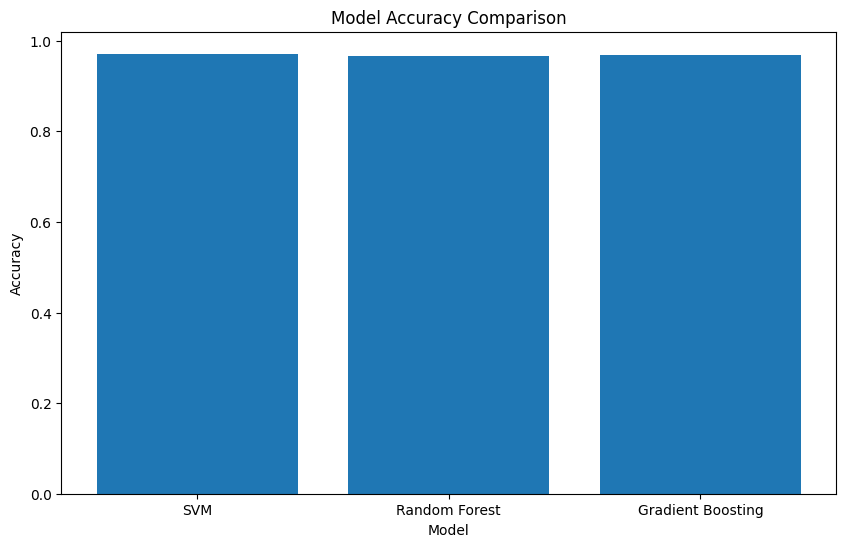

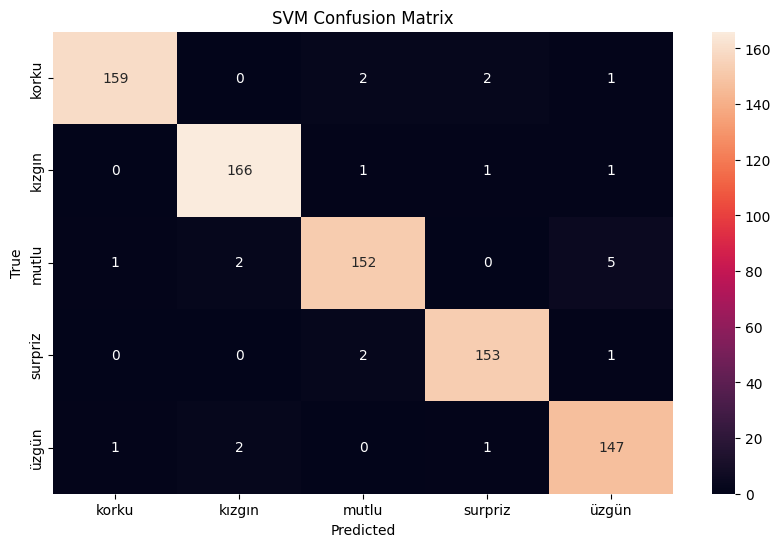

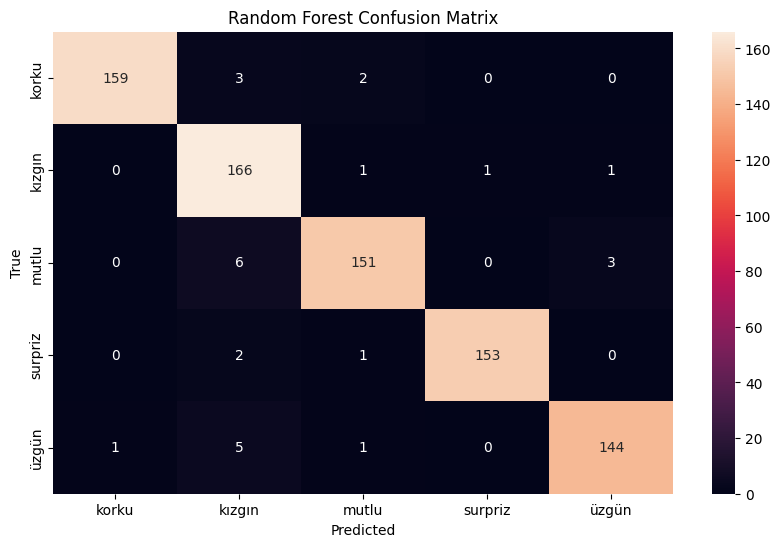

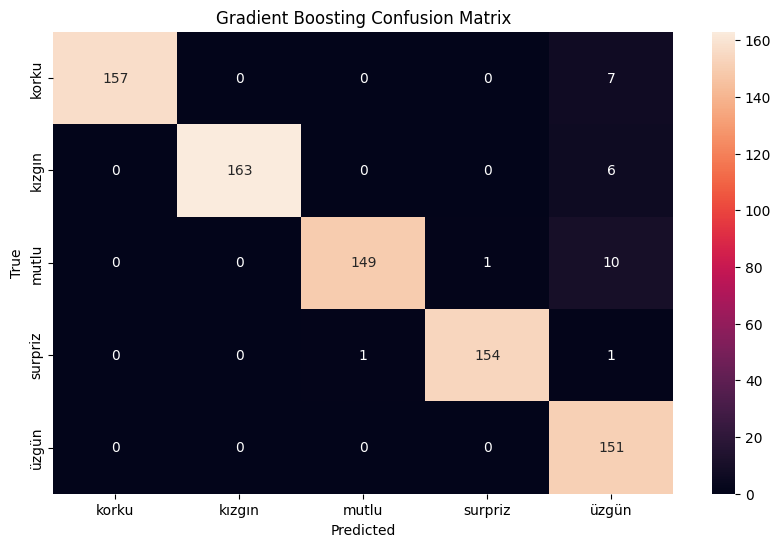

The predicted emotion for the sentence "Bu projeyi gerçekten çok sevdim." is: mutlu


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Load dataset
file_path = '/content/TurkishTweets.csv'
dataset = pd.read_csv(file_path)

# Drop rows with NaN values in 'Tweet' column
dataset = dataset.dropna(subset=['Tweet'])

# Extract features and labels
X = dataset['Tweet']
y = dataset['Etiket']

# Encode sentiment labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess text data using TF-IDF vectorizer with n-grams
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))  # Include unigrams, bigrams, and trigrams
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Function to train and evaluate a model
def train_evaluate_model(model, model_name):
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    labels = sorted(list(set(y_test)))
    target_names = label_encoder.inverse_transform(labels).astype(str)
    report = classification_report(y_test, y_pred, labels=labels, target_names=target_names, zero_division=0)
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    print(f'{model_name} Accuracy: {accuracy}')
    print(f'{model_name} Classification Report:')
    print(report)
    print('------------------------------------------------------')
    return model, accuracy, cm, target_names

# Train and evaluate models
models = {
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

trained_models = {}
accuracies = {}
confusion_matrices = {}

for model_name, model in models.items():
    trained_model, accuracy, cm, target_names = train_evaluate_model(model, model_name)
    trained_models[model_name] = trained_model
    accuracies[model_name] = accuracy
    confusion_matrices[model_name] = (cm, target_names)

# Plot accuracies
plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values())
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.show()

# Plot confusion matrices
for model_name, (cm, target_names) in confusion_matrices.items():
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

# Function to predict emotion from a sentence
def predict_emotion(sentence, model_name):
    model = trained_models[model_name]
    sentence_tfidf = vectorizer.transform([sentence])
    prediction = model.predict(sentence_tfidf)
    emotion = label_encoder.inverse_transform(prediction)
    return emotion[0]

# Example usage
example_sentence = "Bu projeyi gerçekten çok sevdim."
predicted_emotion = predict_emotion(example_sentence, "SVM")  # You can choose "SVM", "Random Forest", or "Gradient Boosting"
print(f'The predicted emotion for the sentence "{example_sentence}" is: {predicted_emotion}')


In [ ]:
example_sentence = "Bu projeyi gerçekten inanılmaz."
predicted_emotion = predict_emotion(example_sentence, "SVM")  # You can choose "SVM", "Random Forest", or "Gradient Boosting"
print(f'The predicted emotion for the sentence "{example_sentence}" is: {predicted_emotion}')

The predicted emotion for the sentence "Bu projeyi gerçekten inanılmaz." is: surpriz
